In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy import stats
import os

# Set the working directory
os.chdir("..")
from utils.config import ROOT
os.chdir(ROOT)

In [ ]:
def get_DF(experiment):
    df_ref = pd.read_pickle(os.path.join("utils","references", "database_reference_MLREADY_{}.pkl".format(experiment)))
    DF = pd.DataFrame()

    for dataframe in os.listdir(os.path.join("robustness_experiment", "results", experiment.lower())):
        if dataframe.endswith(".pkl"):
            df = pd.read_pickle(os.path.join("robustness_experiment", "results", experiment.lower(), dataframe))
            fold, lvl  = dataframe.split("_")[-1].split(".")[0].split("-") 
            df["Image ID"] = [x.split("/")[-1].split(".")[0].split("_")[-1] for x in df["PATH"].values]
            df["Fold"] = int(fold)
            df["LVL"] = int(lvl)
            df["TARGET"] = [k[0] for k in df["TARGET"].values]
            df["PRED"] = [k[0] for k in df["PRED"].values]
            df["correct"] = df["PRED"] == df["TARGET"]
            df_merged = pd.merge(df, df_ref, on="Image ID", how="inner")
            DF = pd.concat([DF, df_merged])

    if experiment == "bias":
        DF["Species depicted in training by"] = np.nan
        DF.loc[(DF["LABEL"] == "aegypti") | (DF["LABEL"] == "koreicus"),"Species depicted in training by"] = "Microscope"
        DF.loc[(DF["LABEL"] == "albopictus") | (DF["LABEL"] == "japonicus"), "Species depicted in training by"] = "Smartphone"

    DF["Image capture device"] = np.nan
    DF.loc[(DF["Device"] == "olympus sz61 + olympus dp23"), "Image capture device"] = "Microscope"
    DF.loc[(DF["Device"] == "macrolens + iphone se"), "Image capture device"] = "Smartphone"
    
    return DF

def get_avg_metric(df, with_ci = True):
    accuracy_ls, f1_ls = [], []
    for fold in df["Fold"].unique():
        df_fold = df.loc[df["Fold"] == fold]

        accuracy_ls.append(metrics.balanced_accuracy_score(df_fold["TARGET"], df_fold["PRED"]))
        f1_ls.append(metrics.f1_score(df_fold["TARGET"], df_fold["PRED"], average="macro"))

    acc_avg = np.mean(accuracy_ls)
    f1_avg = np.mean(f1_ls)

    if with_ci:
        acc_ci = stats.t.interval(0.95, len(accuracy_ls)-1, loc=np.mean(accuracy_ls), scale=stats.sem(accuracy_ls))
        f1_ci = stats.t.interval(0.95, len(f1_ls)-1, loc=np.mean(f1_ls), scale=stats.sem(f1_ls))
    

    return acc_avg*100, f1_avg*100, acc_ci, f1_ci


DF_phone = get_DF("TrainPhone")
DF_olymp = get_DF("TrainOlymp")
DF_bias = get_DF("bias")

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/3359194421.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Microscope' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DF.loc[(DF["Device"] == "olympus sz61 + olympus dp23"), "Image capture device"] = "Microscope"
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/3359194421.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Microscope' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DF.loc[(DF["Device"] == "olympus sz61 + olympus dp23"), "Image capture device"] = "Microscope"
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/3359194421.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'M

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/1440236317.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(["A", "C", "D", "G"], fontsize=12)
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/1440236317.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(["A", "C", "D", "G"], fontsize=12)
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/1440236317.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(["A", "C", "D", "G"], fontsize=12)
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_97480/1440236317.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

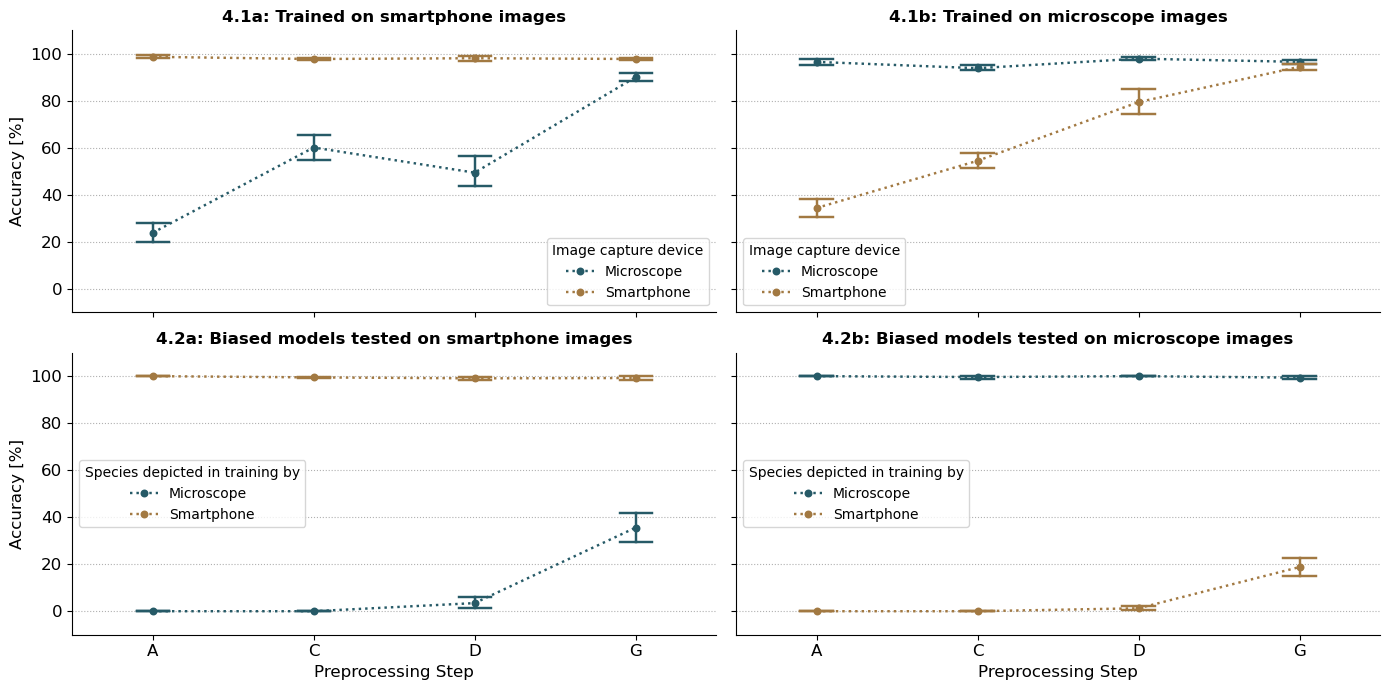

In [4]:
# Group Dataframe by folds as CI are calculated by the average of the folds
DF_phone_g = DF_phone.groupby(["Fold", "LVL", "Image capture device"])["correct"].mean().reset_index()
DF_olymp_g = DF_olymp.groupby(["Fold", "LVL", "Image capture device"])["correct"].mean().reset_index()
DF_bias_g = DF_bias.groupby(["Fold", "LVL", "Species depicted in training by", "Device"])["correct"].mean().reset_index()

colors = ["#265A67", "#A27942"]
fig, ax = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey="row")

ax[0][0].set_title("4.1a: Trained on smartphone images", fontsize=12, fontweight="bold")
sb.pointplot(DF_phone_g, x="LVL", y="correct", hue="Image capture device", linestyle="dotted",
             capsize=.2, linewidth=1.75, errorbar="ci", ax=ax[0][0], palette=colors)
ax[0][1].set_title("4.1b: Trained on microscope images", fontsize=12, fontweight="bold")
sb.pointplot(DF_olymp_g, x="LVL", y="correct", hue="Image capture device", linestyle="dotted",
             capsize=.2, linewidth=1.75, errorbar="ci", ax=ax[0][1], palette=colors)
ax[1][0].set_title("4.2a: Biased models tested on smartphone images", fontsize=12, fontweight="bold")
sb.pointplot(DF_bias_g.loc[DF_bias_g["Device"] == 'macrolens + iphone se'], x="LVL", y="correct", hue="Species depicted in training by", linestyle="dotted",
             capsize=.2, linewidth=1.75, errorbar="ci", ax=ax[1][0], palette=colors)
ax[1][1].set_title("4.2b: Biased models tested on microscope images", fontsize=12, fontweight="bold")
sb.pointplot(DF_bias_g.loc[DF_bias_g["Device"] == 'olympus sz61 + olympus dp23'], x="LVL", y="correct", hue="Species depicted in training by", linestyle="dotted",
             capsize=.2, linewidth=1.75, errorbar="ci", ax=ax[1][1], palette=colors)

for a in ax.ravel():
    a.set_ylim(-0.1, 1.1)
    a.grid(True, axis="y", linestyle="dotted")
    a.set_xlabel("Preprocessing Step", fontsize=12)
    a.set_xticklabels(["A", "C", "D", "G"], fontsize=12)
    a.set_yticks(np.arange(0, 1.1, .2))
    a.set_yticklabels(["0", "20", "40", "60", "80", "100"], fontsize=12)
    a.set_ylabel("Accuracy [%]", fontsize=12)

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

# change legend location for ax[1][1]
handles, labels = ax[1][1].get_legend_handles_labels()
ax[1][1].legend(handles=handles, labels=labels, title="Species depicted in training by" ,loc="center left")

plt.tight_layout()
#plt.savefig("figures/figure_4.png", dpi=300)

In [5]:
# Novel Device Experiment, trained on Smartphone images
for i in range(4):
    print("Preprocessing Level:", i)
    print("Tested on Microscope images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_phone.loc[(DF_phone["Image capture device"] == 'Microscope') & (DF_phone["LVL"] == i)])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

    print("Tested on Smartphone images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_phone.loc[(DF_phone["Image capture device"] == 'Smartphone') & (DF_phone["LVL"] == i)])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

Preprocessing Level: 0
Tested on Microscope images
Accuracy: 23.54% (95% CI: 17.33% - 29.76%)
F1 Score: 17.87% (95% CI: 13.67% - 22.08%)
Tested on Smartphone images
Accuracy: 98.74% (95% CI: 97.72% - 99.75%)
F1 Score: 98.74% (95% CI: 97.75% - 99.74%)
Preprocessing Level: 1
Tested on Microscope images
Accuracy: 60.11% (95% CI: 51.56% - 68.67%)
F1 Score: 54.83% (95% CI: 43.70% - 65.96%)
Tested on Smartphone images
Accuracy: 97.82% (95% CI: 97.05% - 98.58%)
F1 Score: 97.83% (95% CI: 97.07% - 98.58%)
Preprocessing Level: 2
Tested on Microscope images
Accuracy: 49.13% (95% CI: 38.01% - 60.24%)
F1 Score: 43.49% (95% CI: 29.83% - 57.14%)
Tested on Smartphone images
Accuracy: 98.13% (95% CI: 96.49% - 99.77%)
F1 Score: 98.14% (95% CI: 96.51% - 99.76%)
Preprocessing Level: 3
Tested on Microscope images
Accuracy: 90.03% (95% CI: 87.17% - 92.89%)
F1 Score: 90.00% (95% CI: 87.09% - 92.91%)
Tested on Smartphone images
Accuracy: 97.80% (95% CI: 97.20% - 98.40%)
F1 Score: 97.82% (95% CI: 97.21% - 98.4

In [6]:
# Novel Device Experiment, trained on Microscope images
for i in range(4):
    print("Preprocessing Level:", i)
    print("Tested on Smartphone images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_olymp.loc[(DF_olymp["Image capture device"] == 'Smartphone') & (DF_olymp["LVL"] == i)])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

    print("Tested on Microscope images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_olymp.loc[(DF_olymp["Image capture device"] == 'Microscope') & (DF_olymp["LVL"] == i)])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

Preprocessing Level: 0
Tested on Smartphone images
Accuracy: 34.12% (95% CI: 28.25% - 39.99%)
F1 Score: 25.26% (95% CI: 17.68% - 32.84%)
Tested on Microscope images
Accuracy: 96.54% (95% CI: 94.34% - 98.73%)
F1 Score: 96.56% (95% CI: 94.42% - 98.70%)
Preprocessing Level: 1
Tested on Smartphone images
Accuracy: 54.13% (95% CI: 49.01% - 59.25%)
F1 Score: 50.94% (95% CI: 43.53% - 58.34%)
Tested on Microscope images
Accuracy: 93.91% (95% CI: 92.24% - 95.57%)
F1 Score: 93.89% (95% CI: 92.20% - 95.58%)
Preprocessing Level: 2
Tested on Smartphone images
Accuracy: 79.24% (95% CI: 71.25% - 87.24%)
F1 Score: 78.40% (95% CI: 68.63% - 88.18%)
Tested on Microscope images
Accuracy: 97.92% (95% CI: 96.75% - 99.09%)
F1 Score: 97.95% (95% CI: 96.80% - 99.10%)
Preprocessing Level: 3
Tested on Smartphone images
Accuracy: 94.45% (95% CI: 92.20% - 96.71%)
F1 Score: 94.47% (95% CI: 92.24% - 96.70%)
Tested on Microscope images
Accuracy: 96.59% (95% CI: 95.00% - 98.18%)
F1 Score: 96.58% (95% CI: 95.00% - 98.1

In [ ]:
# Bias Experiment
import warnings
warnings.filterwarnings("ignore")

for i in range(4):
    print("Preprocessing Level:", i)
    print("Trained on Smartphone images - Tested on Smartphone images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_bias.loc[(DF_bias["Species depicted in training by"] == 'Smartphone') & (DF_bias["LVL"] == i) & (DF_bias["Device"] == 'macrolens + iphone se')])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")
    print("Trained on Smartphone images - Tested on Microscope images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_bias.loc[(DF_bias["Species depicted in training by"] == 'Smartphone') & (DF_bias["LVL"] == i) & (DF_bias["Device"] == 'olympus sz61 + olympus dp23')])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

    print("Trained on Microscope images - Tested on Microscope images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_bias.loc[(DF_bias["Species depicted in training by"] == 'Microscope') & (DF_bias["LVL"] == i) & (DF_bias["Device"] == 'olympus sz61 + olympus dp23')])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")
    print("Trained on Microscope images - Tested on Smartphone images")
    acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF_bias.loc[(DF_bias["Species depicted in training by"] == 'Microscope') & (DF_bias["LVL"] == i) & (DF_bias["Device"] == 'macrolens + iphone se')])
    print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
    print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")
    print("\n")

Preprocessing Level: 0
Trained on Smartphone images - Tested on Smartphone images
Accuracy: 100.00% (95% CI: nan% - nan%)
F1 Score: 100.00% (95% CI: nan% - nan%)
Trained on Smartphone images - Tested on Microscope images
Accuracy: 0.00% (95% CI: nan% - nan%)
F1 Score: 0.00% (95% CI: nan% - nan%)
Trained on Microscope images - Tested on Microscope images
Accuracy: 100.00% (95% CI: nan% - nan%)
F1 Score: 100.00% (95% CI: nan% - nan%)
Trained on Microscope images - Tested on Smartphone images
Accuracy: 0.00% (95% CI: nan% - nan%)
F1 Score: 0.00% (95% CI: nan% - nan%)


Preprocessing Level: 1
Trained on Smartphone images - Tested on Smartphone images
Accuracy: 99.47% (95% CI: 99.11% - 99.84%)
F1 Score: 99.47% (95% CI: 99.10% - 99.84%)
Trained on Smartphone images - Tested on Microscope images
Accuracy: 0.00% (95% CI: nan% - nan%)
F1 Score: 0.00% (95% CI: nan% - nan%)
Trained on Microscope images - Tested on Microscope images
Accuracy: 99.61% (95% CI: 98.53% - 100.69%)
F1 Score: 99.61% (95%